In [1]:
import numpy as np
import pandas as pd 

In [69]:
try:
    import neuralprophet
except:
    !pip install neuralprophet

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch

In [6]:
def plot_decompose(decompose_result):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,20))
    decompose_result.observed.plot(legend=False,ax=ax1,fontsize = 20,grid=True,linewidth = 3)
    ax1.set_ylabel("Observed",fontsize = 20)
    decompose_result.trend.plot(legend=False,ax=ax2,fontsize = 20,grid=True,linewidth = 3)
    ax2.set_ylabel("Trend",fontsize = 20)
    decompose_result.seasonal.plot(legend=False,ax=ax3,fontsize = 20,grid=True,linewidth = 3)
    ax3.set_ylabel("Seasonal",fontsize = 20)
    decompose_result.resid.plot(legend=False,ax=ax4,fontsize = 20,grid=True,linewidth = 3)
    ax4.set_ylabel("Residual",fontsize = 20)

# EDA (Exploratory Data Analysis)

In [7]:
flight_data = pd.read_csv('oman-morsal.csv')
cm = sns.light_palette("green", as_cmap=True)
flight_data.head(20).style.background_gradient(cmap=cm)

,Month,Passengers
0,01/01/2009,571
1,01/02/2009,626
2,01/03/2009,642
3,01/04/2009,522
4,01/05/2009,552
5,01/06/2009,541
6,01/07/2009,744
7,01/08/2009,696
8,01/09/2009,661
9,01/10/2009,514


In [9]:
print(flight_data.describe())
print('-'*40)
print(flight_data.tail())

       Passengers
count  144.000000
mean   647.187500
std     86.240513
min    500.000000
25%    574.750000
50%    652.000000
75%    710.500000
max    800.000000
----------------------------------------
          Month  Passengers
139  01/08/2020         616
140  01/09/2020         705
141  01/10/2020         685
142  01/11/2020         574
143  01/12/2020         584


In [10]:
flight_data.shape

(144, 2)

In [11]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


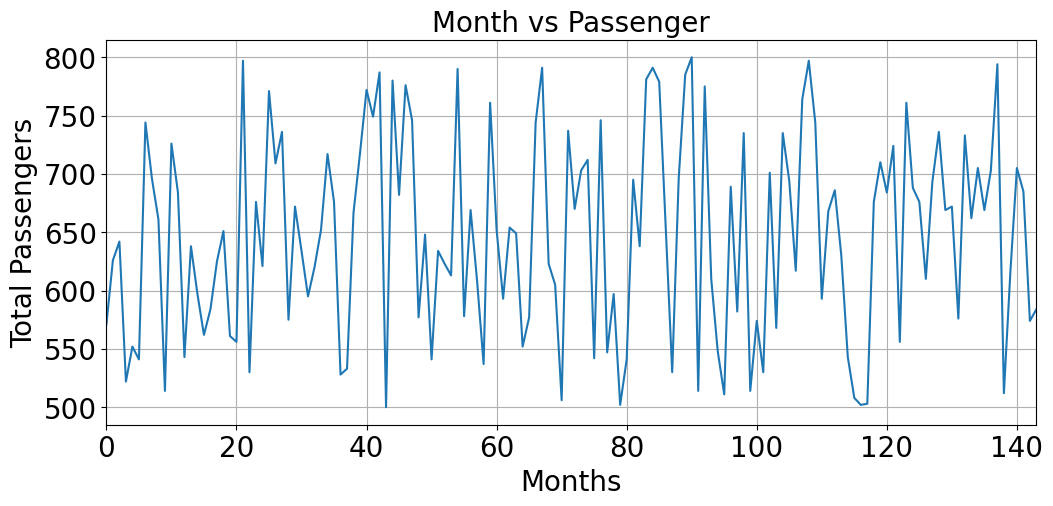

In [13]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(flight_data['Passengers'])

In [14]:
flight_data['Passengers']

0      571
1      626
2      642
3      522
4      552
      ... 
139    616
140    705
141    685
142    574
143    584
Name: Passengers, Length: 144, dtype: int64

Let's decompose time series data into Trend, Seasonality, and Residual through time series decomposition.

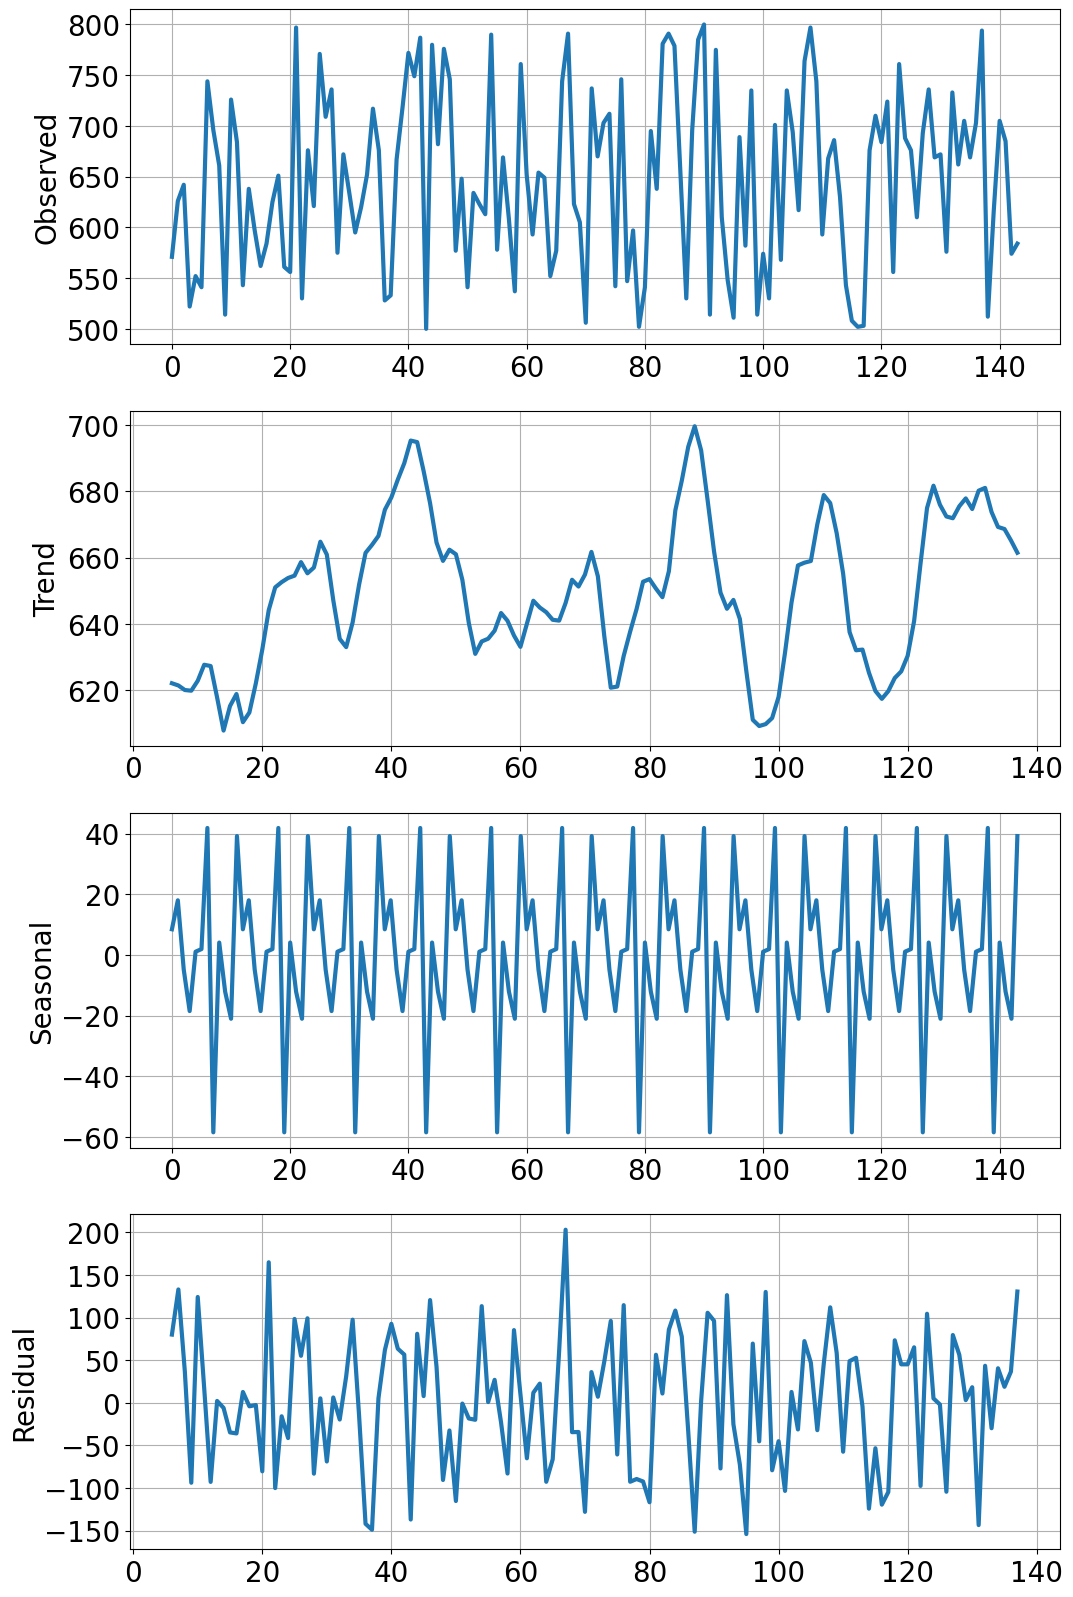

In [16]:
import statsmodels
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(flight_data['Passengers'], period=12) 
plot_decompose(decomposition)

# Preprocessing

In [17]:
all_data = flight_data['Passengers'].values.astype(float)
print(all_data)

[571. 626. 642. 522. 552. 541. 744. 696. 661. 514. 726. 684. 543. 638.
 597. 562. 584. 625. 651. 561. 556. 797. 530. 676. 621. 771. 709. 736.
 575. 672. 634. 595. 620. 652. 717. 676. 528. 533. 667. 718. 772. 749.
 787. 500. 780. 682. 776. 746. 577. 648. 541. 634. 623. 613. 790. 578.
 669. 608. 537. 761. 652. 593. 654. 649. 552. 577. 744. 791. 623. 605.
 506. 737. 670. 703. 712. 542. 746. 547. 597. 502. 541. 695. 638. 781.
 791. 779. 655. 530. 696. 785. 800. 514. 775. 610. 548. 511. 689. 582.
 735. 514. 574. 530. 701. 568. 735. 694. 617. 764. 797. 744. 593. 668.
 686. 630. 543. 508. 502. 503. 676. 710. 684. 724. 556. 761. 688. 676.
 610. 693. 736. 669. 672. 576. 733. 662. 705. 669. 703. 794. 512. 616.
 705. 685. 574. 584.]


In [18]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [19]:
print(len(train_data))
print(len(test_data))

132
12


In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [21]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [22]:
train_window = 12

In [23]:
def create_inout_sequences(input_data, window):
    inout_seq = []
    L = len(input_data)
    for i in range(L-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [24]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [25]:
train_inout_seq[:5]

[(tensor([-0.5267, -0.1600, -0.0533, -0.8533, -0.6533, -0.7267,  0.6267,  0.3067,
           0.0733, -0.9067,  0.5067,  0.2267]),
  tensor([-0.7133])),
 (tensor([-0.1600, -0.0533, -0.8533, -0.6533, -0.7267,  0.6267,  0.3067,  0.0733,
          -0.9067,  0.5067,  0.2267, -0.7133]),
  tensor([-0.0800])),
 (tensor([-0.0533, -0.8533, -0.6533, -0.7267,  0.6267,  0.3067,  0.0733, -0.9067,
           0.5067,  0.2267, -0.7133, -0.0800]),
  tensor([-0.3533])),
 (tensor([-0.8533, -0.6533, -0.7267,  0.6267,  0.3067,  0.0733, -0.9067,  0.5067,
           0.2267, -0.7133, -0.0800, -0.3533]),
  tensor([-0.5867])),
 (tensor([-0.6533, -0.7267,  0.6267,  0.3067,  0.0733, -0.9067,  0.5067,  0.2267,
          -0.7133, -0.0800, -0.3533, -0.5867]),
  tensor([-0.4400]))]

In [26]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [27]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions[-1]

In [28]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [29]:
print(model)

LSTM(
  (lstm): LSTM(1, 128, num_layers=2)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


# Training

In [30]:
epochs = 500

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
 
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   1 loss: 0.23029208
epoch:  26 loss: 0.01647668
epoch:  51 loss: 0.00279252
epoch:  76 loss: 0.00105897
epoch: 101 loss: 0.00000125
epoch: 126 loss: 0.00001015
epoch: 151 loss: 0.00000002
epoch: 176 loss: 0.00001676
epoch: 201 loss: 0.01306977
epoch: 226 loss: 0.00021604
epoch: 251 loss: 0.00000299
epoch: 276 loss: 0.00011486
epoch: 301 loss: 0.00006482
epoch: 326 loss: 0.05735402
epoch: 351 loss: 0.00124860
epoch: 376 loss: 0.00000568
epoch: 401 loss: 0.00000013
epoch: 426 loss: 0.00038554
epoch: 451 loss: 0.00010891
epoch: 476 loss: 0.00020933
epoch: 499 loss: 0.00294335


In [31]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.2266666740179062, 0.4933333396911621, -0.6266666650772095, 0.7400000095367432, 0.25333333015441895, 0.1733333319425583, -0.2666666805744171, 0.2866666615009308, 0.5733333230018616, 0.12666666507720947, 0.14666666090488434, -0.4933333396911621]


In [32]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        test_inputs.append(model(seq).item())

Check the last 12 predictions.

In [33]:
test_inputs[fut_pred:]

[-0.39777737855911255,
 -0.7630208134651184,
 -0.523347020149231,
 -0.006158678792417049,
 -0.10745751112699509,
 0.5860725045204163,
 0.19279108941555023,
 0.4375159740447998,
 -0.10335598140954971,
 -0.29389235377311707,
 -0.14833827316761017,
 0.8499483466148376]

In [34]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[590.33339322]
 [535.54687798]
 [571.49794698]
 [649.07619818]
 [633.88137333]
 [737.91087568]
 [678.91866341]
 [715.62739611]
 [634.49660279]
 [605.91614693]
 [627.74925902]
 [777.49225199]]


In [35]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


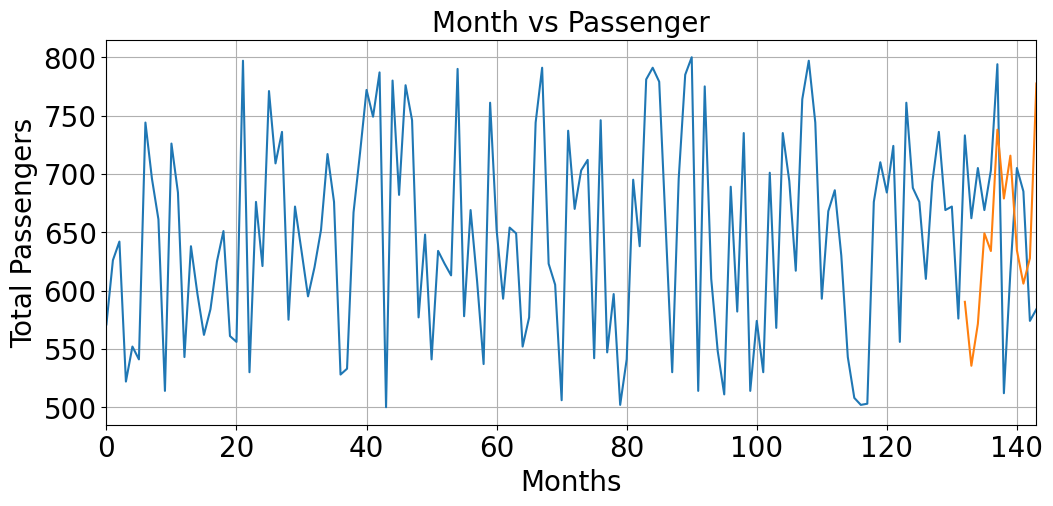

In [37]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(flight_data['Passengers'])
plt.plot(x,actual_predictions)

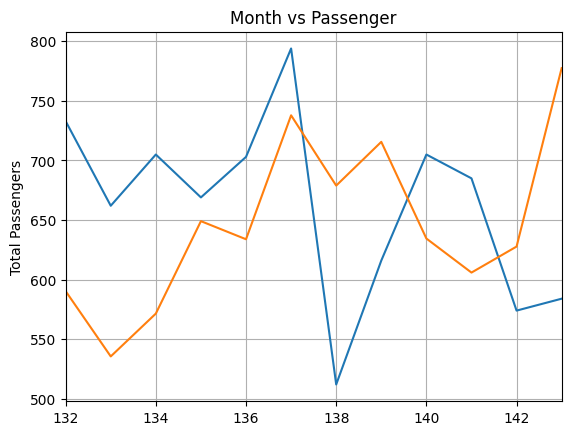

In [38]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['Passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

# Time series analysis with predicted results



In [39]:
flight_data['Passengers'][:-train_window]
train_df = pd.DataFrame(flight_data['Passengers'][:-train_window])
actual_df = pd.DataFrame(actual_predictions)
actual_df.columns = ['Passengers']
new_predict = pd.concat([train_df,actual_df]).reset_index(drop=True)

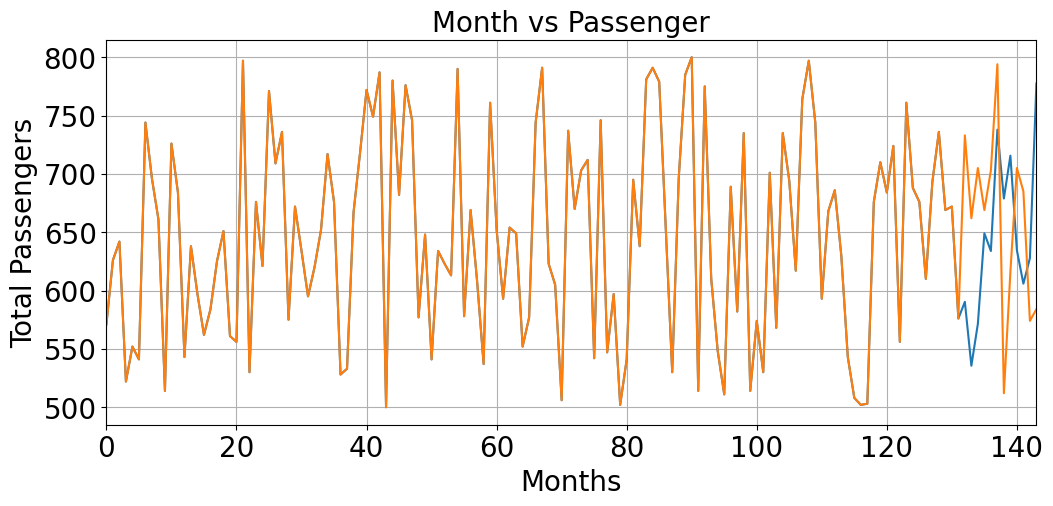

In [40]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(new_predict)
plt.plot(flight_data['Passengers'])

**Let's do a seasonal decomposition analysis with the predicted results.**

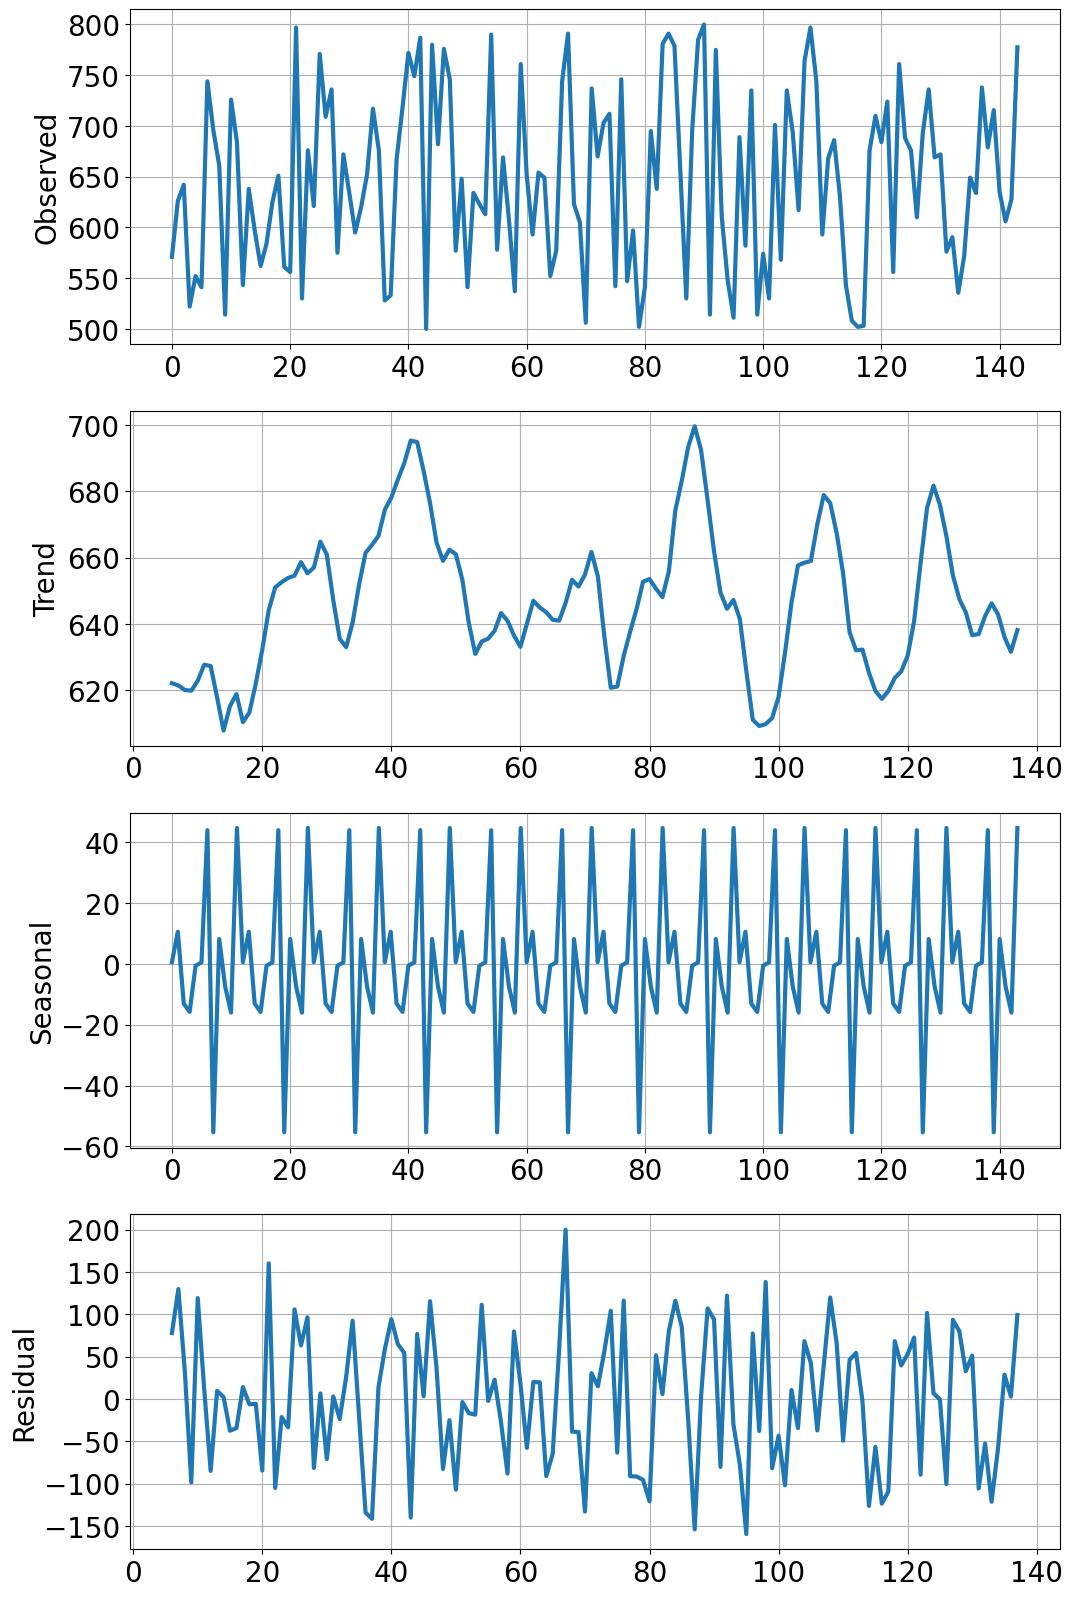

In [41]:
decomposition = seasonal_decompose(new_predict, period=12) 
plot_decompose(decomposition)

Looking at the figure above, it can be confirmed that, despite the simple model, it is predicted while well preserving the trend, seasonality, and residual.



# Predicting by Prophet

In [116]:
df = flight_data.copy()

In [117]:
df.rename(columns={"Passengers": "y"}, inplace=True)


In [118]:
df_new = df.rename(columns={'Month': 'ds'})


In [119]:
print(df_new.head())


           ds    y
0  01/01/2009  571
1  01/02/2009  626
2  01/03/2009  642
3  01/04/2009  522
4  01/05/2009  552


## Trainging

In [120]:
#pip install prophet
#pip install pystan==2.19.1.1
#pip install cmdstanpy

In [121]:
from prophet import Prophet

In [122]:
print(df_new['ds'].isna().sum())


0


In [124]:
df_new = df_new.dropna(subset=['ds'])
df_new

,ds,y
0,01/01/2009,571
1,01/02/2009,626
2,01/03/2009,642
3,01/04/2009,522
4,01/05/2009,552
...,...,...
139,01/08/2020,616
140,01/09/2020,705
141,01/10/2020,685
142,01/11/2020,574


In [125]:
m = Prophet()
m.fit(df_new)

20:14:26 - cmdstanpy - INFO - Chain [1] start processing
20:14:27 - cmdstanpy - INFO - Chain [1] done processing


## Predicting

In [139]:
future = m.make_future_dataframe(periods=500)
forecast = m.predict(future)

In [140]:
#pip install prophet plotly

## Checking results

WARNING - (py.warnings._showwarnmsg) - C:\ProgramData\Anaconda3\lib\site-packages\prophet\plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - C:\ProgramData\Anaconda3\lib\site-packages\prophet\plot.py:349: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')

WARNING - (py.warnings._showwarnmsg) - C:\ProgramData\Anaconda3\lib\site-packages\prophet\plot.py:352: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version t

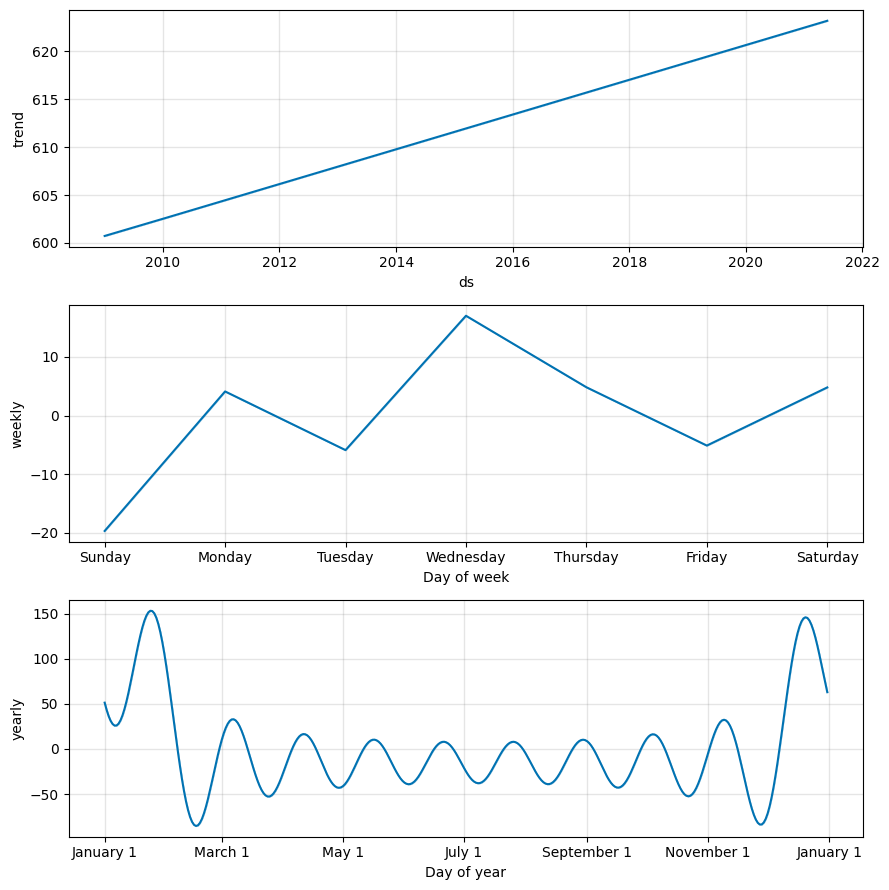

In [141]:
fig2 = m.plot_components(forecast)

In [145]:
import plotly.graph_objects as go
from prophet import Prophet


In [153]:
# from fbprophet.plot import plot_plotly, plot_components_plotly

# plot_plotly(m, forecast)

In [155]:
#plot_components_plotly(m, forecast)

In [156]:
from neuralprophet import NeuralProphet

In [158]:
# m = NeuralProphet()
# metrics = m.fit(df_new, freq="M")
# forecast = m.predict(df_new)

In [ ]:
fig_forecast = m.plot(forecast)
fig_components = m.plot_components(forecast)
fig_model = m.plot_parameters()

# Predicting by NeuralProphet

In [76]:
future = m.make_future_dataframe(df_new, periods=50, n_historic_predictions=len(df_new)-50)
forecast = m.predict(future)
fig_forecast = m.plot(forecast)
fig_components = m.plot_components(forecast)
fig_model = m.plot_parameters()

TypeError: make_future_dataframe() got multiple values for argument 'periods'

<hr style="border: solid 3px blue;">

# Conclusion

The same dataset was predicted using simple RNN ,prophet and NeuralProphet. All of these methods seem to be predictable. However, it is expected that the predictive power will decrease in datasets that do not have constant trend and seasonality. In other words, it seems that an appropriate method should be selected based on the domain knowledge of the corresponding dataset.
